In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import json
import requests
import matplotlib.pyplot as plt
from tabula import read_pdf
from tika import parser # pip install tika
from math import ceil, floor
from tools import get_files_from_dir, download_if_new
from corona import calc_effects, vacs, vac_list, vac_list_cum, population
from assumptions import week_delta

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
current_folder = os.getcwd()
data_folder = os.path.join(current_folder,'corona_data')
try:
    os.mkdir(data_folder)
except:
    print('folder already exists')

folder already exists


### External links

In [5]:
url_vaccinations = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
url_deliveries = 'https://www.bundesgesundheitsministerium.de/fileadmin/Dateien/3_Downloads/C/Coronavirus/Impfstoff/Lieferprognosen_aller_Hersteller_2._Quartal.pdf'

### Downloading files
(including check if the files are new, if not they are deleted directly)

In [6]:
file_path_vaccinations = download_if_new(url_vaccinations,data_folder)
file_path_deliveries = download_if_new(url_deliveries,data_folder)
print('last date in vaccination file status:                      ',dt.datetime.strptime(pd.read_csv(file_path_vaccinations,sep='\t')['date'].iloc[-1],'%Y-%m-%d').strftime('%d.%m.%y'))
raw = parser.from_file(url_deliveries)
print('Delivery file status (out of "metadata": "Last-Modified"): ',dt.datetime.strptime(raw['metadata']['Last-Modified'], '%Y-%m-%dT%H:%M:%SZ').strftime('%d.%m.%y %H:%M'))
print('Delivery file status (out of the pdf-text):                ', raw['content'][raw['content'].find('Stand'):raw['content'].find('2021')+4])

The-file germany_vaccinations_timeseries_v2.tsv is updated - the update file is added to the data-folder
The-file Lieferprognosen_aller_Hersteller_2._Quartal.pdf is not updated


2021-06-07 15:51:46,114 [MainThread  ] [INFO ]  Retrieving https://www.bundesgesundheitsministerium.de/fileadmin/Dateien/3_Downloads/C/Coronavirus/Impfstoff/Lieferprognosen_aller_Hersteller_2._Quartal.pdf to /tmp/fileadmin-dateien-3_downloads-c-coronavirus-impfstoff-lieferprognosen_aller_hersteller_2._quartal.pdf.


last date in vaccination file status:                       06.06.21
Delivery file status (out of "metadata": "Last-Modified"):  02.06.21 11:14
Delivery file status (out of the pdf-text):                 Stand 2. Juni 2021


### Preparing csv-data - Vaccinations already done

In [12]:
df = pd.read_csv(file_path_vaccinations,sep='\t')
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df.rename(columns={'dosen_biontech_erst_kumulativ':'biontech_1_cum','dosen_biontech_zweit_kumulativ':'biontech_2_cum'
                  ,'dosen_moderna_erst_kumulativ':'moderna_1_cum','dosen_moderna_zweit_kumulativ':'moderna_2_cum'
                  ,'dosen_astrazeneca_erst_kumulativ':'astrazeneca_1_cum','dosen_astrazeneca_zweit_kumulativ':'astrazeneca_2_cum'
                  ,'dosen_johnson_kumulativ':'johnson_1_cum'
                  ,'personen_erst_kumulativ': 'all_1','personen_voll_kumulativ': 'all_full'},inplace=True)
columns_begin = ['date','biontech_1_cum','biontech_2_cum','moderna_1_cum','moderna_2_cum','astrazeneca_1_cum','astrazeneca_2_cum'
                 ,'johnson_1_cum','all_1','all_full']
df['week']= df['date'].apply(lambda x: x.isocalendar()[1])
df['weekday']= df['date'].apply(lambda x: x.isocalendar()[2])

df_total = df[[c for c in columns_begin] + [c for c in df if c not in columns_begin]]

df = df_total[['date','week','weekday']+vac_list_cum[:-1]+['all_1','all_full']].copy()
df = calc_effects(df,shift = 14)

print('Doses last day / 7 and / 14 days more early:    ', df['date'].iloc[-1].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-1]/1000000,3), '   ',\
    df['date'].iloc[-8].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-8]/1000000,3), '   ',\
    df['date'].iloc[-15].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-15]/1000000,3))
print('Doses 2nd last day / 7 and / 14 days more early:', df['date'].iloc[-2].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-2]/1000000,3), '   ',\
    df['date'].iloc[-9].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-9]/1000000,3), '   ',\
    df['date'].iloc[-16].strftime('%d.%m.%y'),round(df_total['dosen_differenz_zum_vortag'].iloc[-16]/1000000,3))
print('Total doses:', round(df_total['dosen_kumulativ'].iloc[-1]/1000000,3))

print('1st dose: ',round(df['all_1'].iloc[-1]/1000000,3),'mln')
print('Full dose: ',round(df['all_full'].iloc[-1]/1000000,3),'mln')
print('1st dose working: ',round(df['all_1'].iloc[-15]/1000000,3),'mln')
print('Full dose working: ',round(df['all_full'].iloc[-15]/1000000,3),'mln')
print('1st dose last week: ',round((df['all_1'].iloc[-1] - df['all_1'].iloc[-8])/1000000,3),'mln')
print('Full dose last week: ',round((df['all_full'].iloc[-1] - df['all_full'].iloc[-8])/1000000,3),'mln')

print('Doses last week: ',round((df_total['dosen_kumulativ'].iloc[-1] - df_total['dosen_kumulativ'].iloc[-8])/1000000,3),'mln')
#print('Doses last week: ',round((df_total['dosen_kumulativ'].iloc[-1] - df_total['dosen_kumulativ'].iloc[-8])/1000000,3),'mln')
print('Doses 2nd-last week: ',round((df_total['dosen_kumulativ'].iloc[-8] 
                                     - df_total['dosen_kumulativ'].iloc[-15])/1000000,3),'mln')

print()

rel_net_effect = round(df['net_effect'].iloc[-1] / df['all_1'].iloc[-1],3)
print(f'The current net effect per person with current 1st dose is {rel_net_effect}')
rel_net_effect_2nd = round(df['net_effect_2nd'].iloc[-1] / df['all_full'].iloc[-1],3)
print(f'The current net effect per person with current 2nd dose is {rel_net_effect_2nd}')
current_real_net = round(df['rel_net_effect'].iloc[-1],3)
print(f'The current relative net effect on the population is ',current_real_net)
R_to_1 = round(1 / (1-current_real_net),3)
print(f'A R-rate of {R_to_1} is reduced to one due to the vaccination')
real_net_14 = round(df['rel_net_effect_after_14'].iloc[-1],3)
print(f'The relative net effect in 14 days on the population is ',real_net_14)
R_to_1_14 = round(1 / (1-real_net_14),3)
print(f'In 14 days a R-rate of {R_to_1_14} is reduced to 1.0 due to the vaccination')
                                            
#df.iloc[-10:,:]
df[['date','week','new_1st','new_full','new_total','johnson_1_cum','rel_all_1','rel_all_full','rel_net_effect','R_to_1','rel_net_effect_after_14','R_to_1_14','rel_biontech_14']].iloc[-10:]

Doses last day / 7 and / 14 days more early:     06.06.21 0.273     30.05.21 0.286     23.05.21 0.287
Doses 2nd last day / 7 and / 14 days more early: 05.06.21 0.384     29.05.21 0.41     22.05.21 0.476
Total doses: 54.905
1st dose:  37.992 mln
Full dose:  17.744 mln
1st dose working:  33.619 mln
Full dose working:  11.874 mln
1st dose last week:  2.168 mln
Full dose last week:  3.014 mln
Doses last week:  4.789 mln
Doses 2nd-last week:  4.754 mln

The current net effect per person with current 1st dose is 0.746
The current net effect per person with current 2nd dose is 0.891
The current relative net effect on the population is  0.341
A R-rate of 1.517 is reduced to one due to the vaccination
The relative net effect in 14 days on the population is  0.39
In 14 days a R-rate of 1.639 is reduced to 1.0 due to the vaccination


,date,week,new_1st,new_full,new_total,johnson_1_cum,rel_all_1,rel_all_full,rel_net_effect,R_to_1,rel_net_effect_after_14,R_to_1_14,rel_biontech_14
152,2021-05-28,21,0.0053,0.0064,0.0107,399511,0.4275,0.1720,0.3077,1.4444,0.3623,1.5682,0.7032
153,2021-05-29,21,0.0022,0.0031,0.0049,427034,0.4297,0.1750,0.3102,1.4496,0.3644,1.5733,0.7022
154,2021-05-30,21,0.0013,0.0022,0.0034,437656,0.4311,0.1773,0.3119,1.4533,0.3657,1.5766,0.7019
155,2021-05-31,22,0.0026,0.0043,0.0064,479687,0.4337,0.1816,0.3156,1.4611,0.3683,1.5829,0.7012
156,2021-06-01,22,0.0058,0.0069,0.0117,563525,0.4396,0.1885,0.3211,1.4730,0.3736,1.5964,0.7012
157,2021-06-02,22,0.0074,0.0084,0.0146,664942,0.4470,0.1969,0.3274,1.4868,0.3804,1.6139,0.7025
158,2021-06-03,22,0.0034,0.0047,0.0075,715503,0.4504,0.2016,0.3326,1.4982,0.3836,1.6223,0.7025
159,2021-06-04,22,0.0044,0.0059,0.0094,791276,0.4548,0.2075,0.3371,1.5086,0.3877,1.6331,0.7022
160,2021-06-05,22,0.0015,0.0035,0.0046,817126,0.4563,0.2110,0.3397,1.5144,0.3892,1.6372,0.7017
161,2021-06-06,22,0.0009,0.0026,0.0033,831145,0.4572,0.2135,0.3412,1.5179,0.3902,1.6400,0.7016


<Figure size 432x288 with 0 Axes>

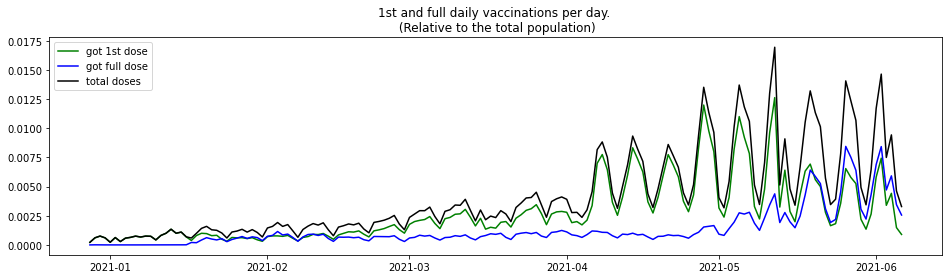

In [13]:
plt.figure('daily vaccinations')
fig = plt.figure(figsize=(16,4))
plt.title('1st and full daily vaccinations per day. \n (Relative to the total population)')
plt.plot(df["date"], df['new_1st'], "-g", label="got 1st dose")
plt.plot(df["date"], df['new_full'], "-b", label="got full dose")
plt.plot(df["date"], df['new_total'], "-k", label="total doses")
plt.legend(loc="upper left")

<Figure size 432x288 with 0 Axes>

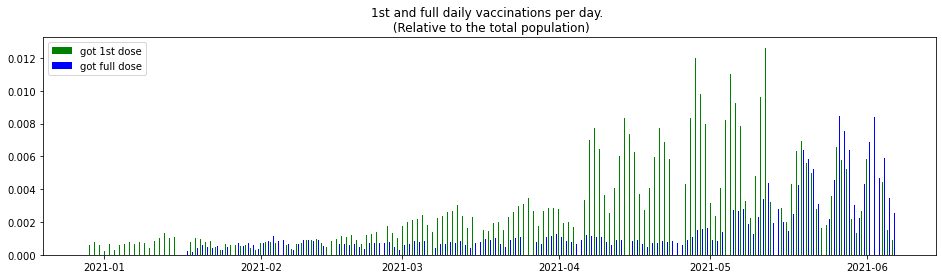

In [14]:
width = 30 / len(df["date"])
next_ = dt.timedelta(hours=12)
plt.figure('daily vaccinations - bar chart')
fig = plt.figure(figsize=(16,4))
plt.title('1st and full daily vaccinations per day. \n (Relative to the total population)')
plt.bar(df["date"], df['new_1st'], color = "g", label="got 1st dose", width=width)
plt.bar(df["date"] + next_, df['new_full'], color = "b", label="got full dose", width=width)
plt.legend(loc="upper left")

### Analysis - how much time is in average between the first and the second dose per vaccine

In [15]:
average_for_days = 31

for vac in ['biontech','moderna','astrazeneca']:
    print(vac)
    df1 = df[['date',vac+'_1_cum']].rename(columns={vac+'_1_cum':vac+'_n'})
    df2 = df[['date',vac+'_2_cum']].rename(columns={vac+'_2_cum':vac+'_n', 'date':'date_2nd'})
    vac_max = df2[vac+'_n'].max()
    print('2nd dose:', round(vac_max/1000000,3))
    dfn = pd.merge_asof(df1[(df1[vac+'_n'] <= vac_max)],df2, on=vac+'_n')
    dfn['2nd_days'] = dfn['date_2nd']-dfn['date']
    average_time_to_2nd_dose = (dfn.iloc[-1-average_for_days:-1]['2nd_days'].mean())#.total_days()
    print(f'average_time_to_2nd_dose last {average_for_days} days       ', average_time_to_2nd_dose)
    average_time_to_2nd_dose_last_14 = (dfn.iloc[-15:-1]['2nd_days'].mean())
    print('average_time_to_2nd_dose_last_14     ', average_time_to_2nd_dose_last_14)
    print(dfn.iloc[-1:,:])    
    print()

biontech
2nd dose: 14.695
average_time_to_2nd_dose last 31 days        35 days 01:32:54.193548
average_time_to_2nd_dose_last_14      36 days 15:25:42.857142
          date  biontech_n   date_2nd 2nd_days
121 2021-04-27    13858197 2021-06-02  36 days

moderna
2nd dose: 1.321
average_time_to_2nd_dose last 31 days        36 days 13:56:07.741935
average_time_to_2nd_dose_last_14      36 days 00:00:00
          date  moderna_n   date_2nd 2nd_days
123 2021-04-29    1294346 2021-06-04  36 days

astrazeneca
2nd dose: 0.897
average_time_to_2nd_dose last 31 days        64 days 01:32:54.193548
average_time_to_2nd_dose_last_14      80 days 22:17:08.571428
         date  astrazeneca_n   date_2nd 2nd_days
68 2021-03-05         891013 2021-06-05  92 days



### Read pdf - planned deliveries

In [16]:
df_pdf = read_pdf(file_path_deliveries, pages='all')

In [17]:
df_pdf[0].columns = ['NaN','week','biontech','moderna','astra','johnson']
df_deliveries = df_pdf[0][['week','biontech','moderna','astra','johnson']]

In [18]:
#df_deliveries = df_pdf[0][['Woche', 'BioNTech', 'Moderna', 'AstraZeneca','Johnson &']].copy()
#df_deliveries.rename(columns={'Woche':'week', 'BioNTech':'biontech', 'Moderna':'moderna', 'AstraZeneca':'astra','Johnson &':'johnson'},inplace='True')
df_deliveries = df_deliveries[(df_deliveries['week'].str.slice(0,2)=='KW')].fillna(0)
for col in df_deliveries.columns[1:]:
    df_deliveries[col] = np.where(df_deliveries[col] == '-', 0, df_deliveries[col])
    df_deliveries[col] = df_deliveries[col].str.replace('.','').fillna(0)
    df_deliveries[col] = df_deliveries[col].astype(int)
date_end = dt.datetime(2021,1,3)
#df_deliveries['days'] = df_deliveries['week'].str.slice(-2,).astype(int).astype(int)*7
#df_deliveries['week_end'] = df_deliveries['days'].apply(lambda x: date_end + dt.timedelta(days = x))

df_deliveries['week_end'] = df_deliveries['week'].apply(lambda x: date_end + dt.timedelta(days = int(x[-2:])*7))
df_deliveries['week'] = df_deliveries['week'].str.slice(-2).astype(int)
df_deliveries.rename(columns={'astra': 'astrazeneca'},inplace=True)

### parameter for outputs

In [19]:
# number of rows and the end of df_deliveries which do not seem to already have proper numbers:
# cut_rows = 3
cut_rows = df_deliveries[(df_deliveries.biontech == 0)]['biontech'].count()

### Forecast

In [76]:
df_week = df[['date','week']+vac_list_cum][(df['weekday'] == 7)].reset_index()
df_week['actuals'] = True
#df_week = df_week[['date','week','actuals'] + [col for col in df_week.columns if col not in ['date','week','actuals']] ]
week_last = df_week['week'].iloc[-1]
actual_end = df_week.index[-1]

for vac in vac_list_cum:
    df_week[vac[:-4]] = df_week[vac]-df_week[vac].shift(1)
df_week = df_week.merge(df_deliveries,how = 'outer', on = 'week')
df_week['actuals'] = df_week['actuals'].fillna(False)
df_week['astrazeneca'].iloc[23:27] = df_week['astrazeneca'].iloc[23:27].mean()
df_week['date'].iloc[10:] = df_week['week'].iloc[10:].apply(lambda x: date_end + dt.timedelta(days = x*7))
df_week = df_week[['date','week','actuals']+vac_list+vacs+vac_list_cum]
df_week.iloc[-10:-cut_rows]

for i in df_week.index:
    if df_week.iloc[i]['week'] > week_last and df_week.iloc[i]['week'] < 52:
        #print(df_week.iloc[i]['week'])
        for vac in week_delta.keys():
            df_week.at[i,vac + '_2'] = min(df_week.iloc[i-1][vac],df_week.iloc[i-week_delta[vac]][vac + '_1'])
            df_week.at[i,vac + '_1'] = df_week.iloc[i-1][vac]-df_week.at[i,vac + '_2']
            df_week.at[i,'johnson_1'] = df_week.iloc[i-1]['johnson']
            df_week['johnson_2'] = df_week['johnson_1']
        for vac in vac_list:
            df_week.at[i, vac+'_cum'] = df_week.at[i - 1, vac+'_cum'] + df_week.at[i, vac]
df_week = calc_effects(df_week,shift=2)

df_week.iloc[-10:-cut_rows]

/home/thomas/python/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,date,week,actuals,biontech_1,biontech_2,moderna_1,moderna_2,astrazeneca_1,astrazeneca_2,johnson_1,johnson_2,biontech,moderna,astrazeneca,johnson,biontech_1_cum,biontech_2_cum,moderna_1_cum,moderna_2_cum,astrazeneca_1_cum,astrazeneca_2_cum,johnson_1_cum,johnson_2_cum,net_effect,net_effect_2nd,rel_net_effect,net_effect_after_14,rel_net_effect_after_14,rel_biontech_14,rel_moderna_14,rel_astrazeneca_14,rel_johnson_14,all_full,all_1,rel_all_1,rel_all_full,R_to_1,R_to_1_14,new_1st,new_full,new_total
21,2021-05-23,20,True,1492302.0000,2023508.0000,408566.0000,181519.0000,732554.0000,157467.0000,75045.0000,75045.0000,3408210.0000,550800.0000,465600.0000,295150.0000,22865838.0000,10348198.0000,2549645.0000,884443.0000,8071755.0000,510694.0000,130917.0000,130917.0000,22978205.0500,10660731.9100,0.2765,28352695.8100,0.3412,0.7088,0.0707,0.2174,0.0030,11874252.0000,33618155.0000,0.4046,0.1429,1.3822,1.5179,0.0326,0.0293,0.0610
22,2021-05-30,21,True,1160463.0000,2192272.0000,313716.0000,183420.0000,423669.0000,172618.0000,306693.0000,306693.0000,3409380.0000,550800.0000,0.0000,724300.0000,24026301.0000,12540470.0000,2863361.0000,1067863.0000,8495424.0000,683312.0000,437610.0000,437610.0000,25918857.4200,13117963.5400,0.3119,30389489.9300,0.3657,0.7019,0.0747,0.2138,0.0095,14729255.0000,35822696.0000,0.4311,0.1772,1.4533,1.5765,0.0265,0.0344,0.0572
23,2021-06-06,22,False,45097.0000,3364283.0000,268956.0000,281844.0000,0.0000,0.0000,724300.0000,724300.0000,5135130.0000,550800.0000,610500.0000,513600.0000,24071398.0000,15904753.0000,3132317.0000,1349707.0000,8495424.0000,683312.0000,1161910.0000,1161910.0000,28352695.8100,16869888.2100,0.3412,31600594.4600,0.3803,0.6901,0.0801,0.2056,0.0243,19099682.0000,36861049.0000,0.4436,0.2298,1.5179,1.6136,0.0125,0.0526,0.0564
24,2021-06-13,23,False,2559296.0000,2575834.0000,170724.0000,380076.0000,362584.0000,247916.0000,513600.0000,513600.0000,4585230.0000,550800.0000,610500.0000,240000.0000,26630694.0000,18480587.0000,3303041.0000,1729783.0000,8858008.0000,931228.0000,1675510.0000,1675510.0000,30389489.9300,20116724.8900,0.3657,34878016.2000,0.4197,0.6950,0.0787,0.1946,0.0317,22817108.0000,40467253.0000,0.4870,0.2746,1.5765,1.7233,0.0434,0.0447,0.0819
25,2021-06-20,24,False,2154129.0000,2431101.0000,192519.0000,358281.0000,0.0000,610500.0000,240000.0000,240000.0000,4035330.0000,585600.0000,610500.0000,0.0000,28784823.0000,20911688.0000,3495560.0000,2088064.0000,8858008.0000,1541728.0000,1915510.0000,1915510.0000,31600594.4600,23491222.2000,0.3803,37379808.6600,0.4498,0.7042,0.0794,0.1826,0.0338,26456990.0000,43053901.0000,0.5181,0.3184,1.6136,1.8176,0.0311,0.0438,0.0720
26,2021-06-27,25,False,2543028.0000,1492302.0000,177034.0000,408566.0000,197597.0000,412903.0000,0.0000,0.0000,5962320.0000,622800.0000,610500.0000,0.0000,31327851.0000,22403990.0000,3672594.0000,2496630.0000,9055605.0000,1954631.0000,1915510.0000,1915510.0000,34878016.2000,25759464.7000,0.4197,40060104.0800,0.4821,0.7140,0.0798,0.1747,0.0316,28770761.0000,45971560.0000,0.5532,0.3462,1.7233,1.9308,0.0351,0.0278,0.0630
27,2021-07-04,26,False,4801857.0000,1160463.0000,309084.0000,313716.0000,0.0000,610500.0000,0.0000,0.0000,5962320.0000,622800.0000,0.0000,0.0000,36129708.0000,23564453.0000,3981678.0000,2810346.0000,9055605.0000,2565131.0000,1915510.0000,1915510.0000,37379808.6600,27836868.9400,0.4498,44479904.8100,0.5353,0.7349,0.0785,0.1582,0.0284,30855440.0000,51082501.0000,0.6147,0.3713,1.8176,2.1517,0.0615,0.0251,0.0866


### Overview table about the most important current and future developments

In [87]:
df_week[['date','week','actuals','new_total','new_1st','new_full','rel_all_1','rel_all_full','rel_net_effect', \
         'R_to_1','rel_net_effect_after_14','R_to_1_14','rel_biontech_14']].iloc[-cut_rows-12:-cut_rows]

,date,week,actuals,new_total,new_1st,new_full,rel_all_1,rel_all_full,rel_net_effect,R_to_1,rel_net_effect_after_14,R_to_1_14,rel_biontech_14
16,2021-04-18,15,True,0.0442,0.0384,0.0057,0.1996,0.0669,0.1093,1.1228,0.1681,1.2021,0.6988
17,2021-04-25,16,True,0.0423,0.0371,0.0053,0.2366,0.0721,0.1366,1.1582,0.1983,1.2474,0.6912
18,2021-05-02,17,True,0.0564,0.0480,0.0085,0.2846,0.0806,0.1681,1.2021,0.2381,1.3126,0.7189
19,2021-05-09,18,True,0.0603,0.0459,0.0147,0.3304,0.0953,0.1983,1.2474,0.2765,1.3822,0.7163
20,2021-05-16,19,True,0.0594,0.0415,0.0183,0.3720,0.1136,0.2381,1.3126,0.3119,1.4533,0.7180
21,2021-05-23,20,True,0.0610,0.0326,0.0293,0.4046,0.1429,0.2765,1.3822,0.3412,1.5179,0.7088
22,2021-05-30,21,True,0.0572,0.0265,0.0344,0.4311,0.1772,0.3119,1.4533,0.3657,1.5765,0.7019
23,2021-06-06,22,False,0.0564,0.0125,0.0526,0.4436,0.2298,0.3412,1.5179,0.3803,1.6136,0.6901
24,2021-06-13,23,False,0.0819,0.0434,0.0447,0.4870,0.2746,0.3657,1.5765,0.4197,1.7233,0.6950
25,2021-06-20,24,False,0.0720,0.0311,0.0438,0.5181,0.3184,0.3803,1.6136,0.4498,1.8176,0.7042


### Plots with new and total vaccinations

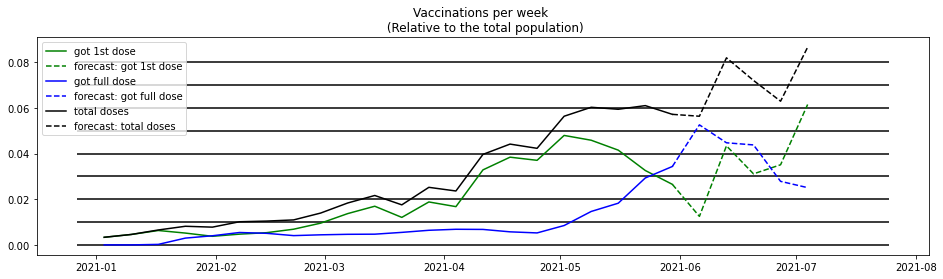

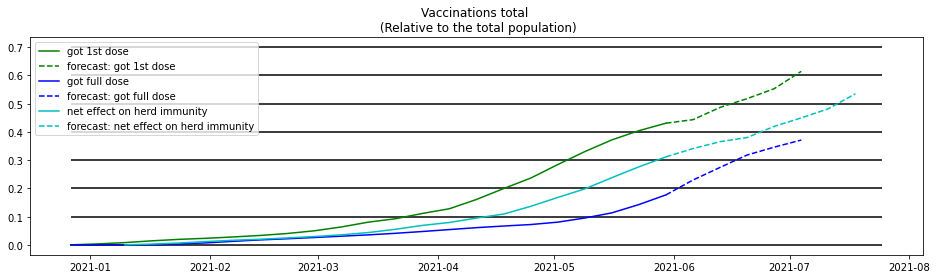

In [84]:
plt.figure('weekly vaccinations',figsize=(16,4))
#plt.subplot(2,2,1)
plt.title('Vaccinations per week \n (Relative to the total population)')
plt.hlines(np.array(range(ceil(df_week['new_total'].max()*100)))/100,df_week["date"][0],df_week["date"].iloc[-1])
plt.plot(df_week["date"][:actual_end+1], df_week['new_1st'][:actual_end+1], "-g", ls="-", label="got 1st dose")
plt.plot(df_week["date"][actual_end:-cut_rows], df_week['new_1st'][actual_end:-cut_rows], "-g", ls="--", label="forecast: got 1st dose")
plt.plot(df_week["date"][:actual_end+1], df_week['new_full'][:actual_end+1], "-b", ls="-", label="got full dose")
plt.plot(df_week["date"][actual_end:-cut_rows], df_week['new_full'][actual_end:-cut_rows], "-b", ls="--", label="forecast: got full dose")
plt.plot(df_week["date"][:actual_end+1], df_week['new_total'][:actual_end+1], "-k", ls="-", label="total doses")
plt.plot(df_week["date"][actual_end:-cut_rows], df_week['new_total'][actual_end:-cut_rows], "-k", ls="--", label="forecast: total doses")
plt.legend(loc="upper left")

plt.figure('weekly total',figsize=(16,4))
#plt.subplot(2,2,2)
plt.title('Vaccinations total \n (Relative to the total population)')
plt.hlines(np.array(range(ceil(df_week['rel_all_1'].max()*10)))/10,df_week["date"][0],df_week["date"].iloc[-1])
plt.plot(df_week["date"][:actual_end+1], df_week['rel_all_1'][:actual_end+1], "-g", ls="-", label="got 1st dose")
plt.plot(df_week["date"][actual_end:-cut_rows], df_week['rel_all_1'][actual_end:-cut_rows], "-g", ls="--", label="forecast: got 1st dose")
plt.plot(df_week["date"][:actual_end+1], df_week['rel_all_full'][:actual_end+1], "-b", ls="-", label="got full dose")
plt.plot(df_week["date"][actual_end:-cut_rows], df_week['rel_all_full'][actual_end:-cut_rows], "-b", ls="--", label="forecast: got full dose")
plt.plot(df_week["date"][:actual_end+1], df_week['rel_net_effect'][:actual_end+1], "-c", ls="-", label="net effect on herd immunity")
plt.plot(df_week["date"][actual_end:-cut_rows+2], df_week['rel_net_effect'][actual_end:-cut_rows+2], "-c", ls="--", label="forecast: net effect on herd immunity")
plt.legend(loc="upper left")

### Relevant information for beginning of July - the time for which a useful delivery forecast is available 

In [19]:
df_week = df_week[:cut_rows].copy()
print('date: ',df_week.date.iloc[-cut_rows])
print('1st dose: ',round(df_week['all_1'].iloc[-cut_rows]/1000000,3),'mln')
print('Full dose: ',round(df_week['all_full'].iloc[-cut_rows]/1000000,3),'mln')
print('1st dose working: ',round(df_week['all_1'].iloc[-cut_rows]/1000000,3),'mln')
print('Full dose working: ',round(df_week['all_full'].iloc[-cut_rows]/1000000,3),'mln')
print()

rel_net_effect = round(df_week['net_effect'].iloc[-cut_rows] / df_week['all_1'].iloc[-cut_rows],3)
print(f'The current net effect per person with current 1st dose is {rel_net_effect}')
rel_net_effect_2nd = round(df_week['net_effect_2nd'].iloc[-cut_rows] / df_week['all_full'].iloc[-cut_rows],3)
print(f'The current net effect per person with current 2nd dose is {rel_net_effect_2nd}')
current_real_net = round(df_week['rel_net_effect'].iloc[-cut_rows],3)
print(f'The current relative net effect on the population is ',current_real_net)
R_to_1 = round(1 / (1-current_real_net),3)
print(f'A R-rate of {R_to_1} is reduced to one due to the vaccination')
real_net_14 = round(df_week['rel_net_effect_after_14'].iloc[-cut_rows],3)
date_14 = df_week.date.iloc[-cut_rows] + dt.timedelta(days = 14)
print(f'The relative net effect in 14 days ({date_14}) on the population is ',real_net_14)
R_to_1_14 = round(1 / (1-real_net_14),3)
print(f'In 14 days at the {date_14} a R-rate of {R_to_1_14} is reduced to 1.0 due to the vaccination')

date:  2021-07-04 00:00:00
1st dose:  51.083 mln
Full dose:  30.855 mln
1st dose working:  43.054 mln
Full dose working:  26.457 mln

The current net effect per person with current 1st dose is 0.732
The current net effect per person with current 2nd dose is 0.902
The current relative net effect on the population is  0.45
A R-rate of 1.818 is reduced to one due to the vaccination
The relative net effect in 14 days (2021-07-18 00:00:00) on the population is  0.535
In 14 days at the 2021-07-18 00:00:00 a R-rate of 2.151 is reduced to 1.0 due to the vaccination
